## Activity Transforms

Here we test the fidelity of activity transformations comparing endogenous and
exogenous datasets

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
from scipy import stats
import plotnine as gg
import matplotlib.pyplot as plt

from core import (add_transform_col, add_xy_line, setup_plots)

In [2]:
setup_plots()

In [6]:
doench2014_human_lfcs = pd.read_csv('../data/interim/Doench2014_human_lfc.csv')
doench2014_mouse_lfcs = pd.read_csv('../data/interim/Doench2014_mouse_lfc.csv')
doench2016_lfcs = pd.read_csv('../data/interim/Doench2016_lfc.csv')
kim_processed_data = pd.read_csv('../data/external/Kim2019_train_activity_v1.csv')

In [7]:
doench2014_human_lfcs['dataset'] = 'Doench2014_human'
doench2014_mouse_lfcs['dataset'] = 'Doench2014_mouse'
doench2016_lfcs['dataset'] = 'Doench2016'

relevant_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'condition', 'dataset', 'Target Gene Symbol', 'lfc']
long_lfcs = pd.concat([doench2014_human_lfcs[relevant_cols],
                       doench2014_mouse_lfcs[relevant_cols],
                       doench2016_lfcs.rename({'avg_lfc': 'lfc'}, axis=1)
                       [relevant_cols]
                       ]).reset_index(drop=True)

In [8]:
transforms = ['yeo-johnson', 'z-score', 'quantile-uniform',
              'robust-scaler', 'min-max-scaler', 'quantile-normal']
transformed_list = []
for transform in transforms:
    transformed_endog = add_transform_col(long_lfcs, 'lfc',
                                          transform, 'endogenous',
                                          group_col=['Target Gene Symbol', 'condition', 'dataset'])
    transformed_exog = add_transform_col(kim_processed_data, 'indel_freq',
                                         transform, 'exogenous')
    merged_transform = (transformed_endog.merge(transformed_exog,
                                                how='inner',
                                                on=['sgRNA Sequence',
                                                    'sgRNA Context Sequence']))
    merged_transform['transform'] = transform
    transformed_list.append(merged_transform)
transformed_df = pd.concat(transformed_list).reset_index(drop=True)

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. 

In [9]:
dataset_n_sgrnas = (long_lfcs.groupby('dataset')
                    .agg(n_sgrnas = ('sgRNA Sequence', 'count'))
                    .reset_index())

pearson_r_data_transform = (transformed_df.groupby(['dataset', 'transform'])
                            .apply(lambda df: stats.pearsonr(df['exogenous'], df['endogenous'])[0])
                            .reset_index()
                            .rename({0: 'pearson'}, axis=1)
                            .merge(dataset_n_sgrnas,
                                   how='inner', on='dataset'))
pearson_r_data_transform['dataset_name'] = (pearson_r_data_transform['dataset'] + '\n(n = ' +
                                            pearson_r_data_transform['n_sgrnas'].astype(int).astype(str) + ')')

pearson_summary =  (pearson_r_data_transform
                    .groupby('transform')
                    .agg({'pearson': 'mean'})
                    .reset_index()
                    .sort_values('pearson', ascending=False))
pearson_r_data_transform['transform'] = pd.Categorical(pearson_r_data_transform['transform'],
                                                       categories=pearson_summary['transform'])

Saving 2 x 2 in image.
Filename: ../figures/exog_endog_data_transforms.pdf


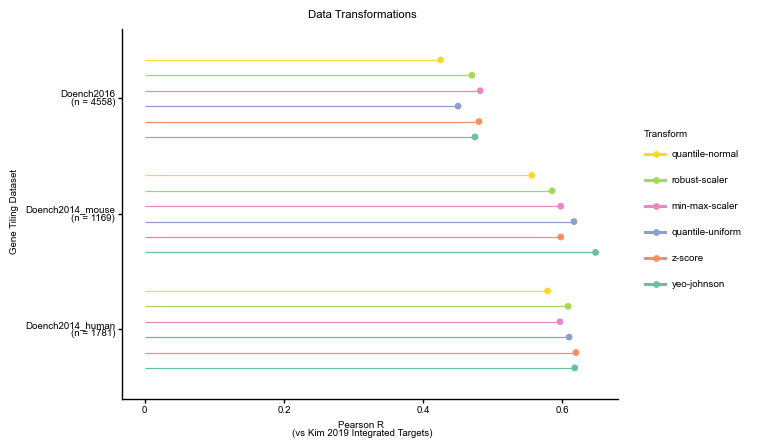

<ggplot: (8787982028502)>

In [10]:
val = 'pearson'
cat = 'dataset_name'
val_label = 'Pearson R \n(vs Kim 2019 Integrated Targets)'
cat_label = 'Gene Tiling Dataset'
color = 'transform'
dodge = gg.position_dodge(width=0.8)
g = (gg.ggplot(pearson_r_data_transform) +
     gg.aes(y=val, ymin=0, ymax=val, x=cat, xend=cat,
            color=color) +
     gg.geom_point(size=4, shape='.',
                   position=dodge) +
     gg.geom_linerange(position=dodge) +
     gg.xlab(cat_label) +  # Flipping before coord flip
     gg.ylab(val_label) +
     gg.coord_flip() +
     gg.ggtitle('Data Transformations') +
     gg.scale_color_brewer(type='qual',
                           palette='Set2') +
     gg.guides(color=gg.guide_legend(reverse=True,
                                     title='Transform')))
g.save('../figures/exog_endog_data_transforms.pdf',
       width=2, height=2)
g

In [11]:
transformed_df['transform'] = pd.Categorical(transformed_df['transform'],
                                             categories=pearson_summary['transform'])

In [ ]:
g = sns.FacetGrid(data=transformed_df, row='transform', col='dataset', sharex=False, sharey=False,
                  aspect=1, margin_titles=True, height=1.3)
g.map_dataframe(gpplot.point_densityplot, x='exogenous', y='endogenous', s=5)
g.map_dataframe(gpplot.add_correlation, x='exogenous', y='endogenous', color='black')
g.map(add_xy_line, color='black')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels(x_var='Exogenous Activity',
                  y_var='Endogenous Activity')
g.fig.tight_layout()
g.savefig('../figures/normlization_methods.pdf', dpi=300)

In [ ]:
plt.subplots(figsize=(2, 2))
yeo_johnson_df = (transformed_df[transformed_df['transform'] == 'yeo-johnson']
                  .reset_index(drop=True))
gpplot.point_densityplot(data=yeo_johnson_df, x='exogenous', y='endogenous', s=8)
gpplot.add_correlation(data=yeo_johnson_df, x='exogenous', y='endogenous', color='black')
gpplot.add_xy_line()
sns.despine()
plt.xlabel('Exogenous activity\n(transformed indel frequency)')
plt.ylabel('Endogenous activity\n(transformed log-fold change)')
gpplot.savefig('../figures/exog_endog_comparison_yj.pdf', dpi=300)